In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D


import cv2
import pandas as pd
import random
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [2]:
#folosit pentru a testa daca placa video este utilizata de tensorflow 
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.__version__)
print(keras.__version__)

Default GPU Device: /device:GPU:0
2.10.0
2.10.0


In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [4]:
#importam datele
datadir = 'training_data'
columns = ['image', 'steering', 'throttle', 'reverse', 'speed','empty']
data = pd.read_csv(os.path.join(datadir, 'data.csv'), names=columns, header=None, delimiter=',')
pd.set_option('display.max_colwidth', None)

# modificam path-ul 
data['image'] = data['image'].apply(path_leaf)
data.head()

,image,steering,throttle,reverse,speed,empty
0,CameraView_00.jpeg,0.1,1.0,0.0,0.0,NaN
1,CameraView_01.jpeg,0.1,1.0,0.0,0.0,NaN
2,CameraView_02.jpeg,0.1,1.0,0.0,0.0,NaN
3,CameraView_03.jpeg,0.1,1.0,0.0,0.0,NaN
4,CameraView_04.jpeg,0.1,1.0,0.0,0.0,NaN


Total data: 9852


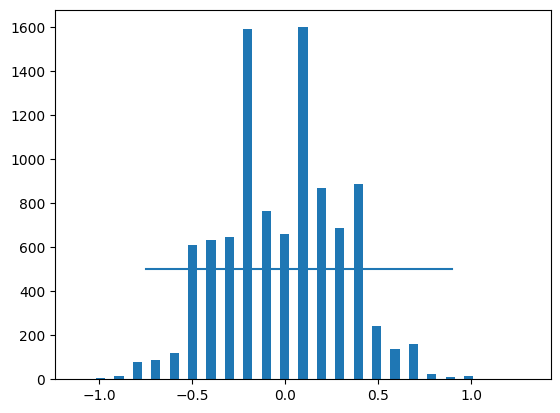

In [5]:
#vizualizam datele si distributia lor
num_bins = 25
samples_per_bin = 500
hist, bins = np.histogram(data['steering'], 25)
center = bins[:-1] + bins[1:] * 0.5 

plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.bar(center, hist, width=0.05)

print('Total data: {0}'.format(len(data)))

Data removed: 3956
Data remaining: 5896


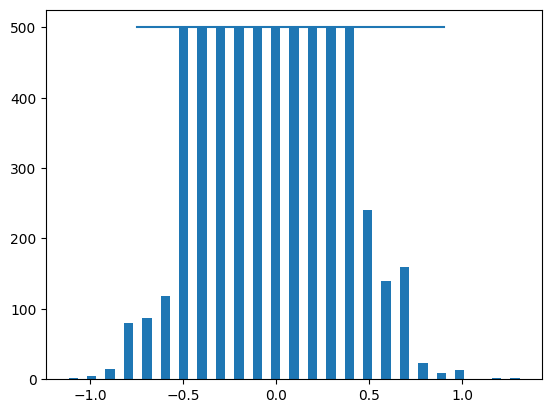

In [6]:
# stergem datele nefolositoare 
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        steering_angle = data['steering'][i]
        if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
  

data.drop(data.index[remove_list], inplace=True)
print('Data removed: {0}'.format(len(remove_list)))
print('Data remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
     

In [7]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        image = indexed_data[0]
        image_path.append(os.path.join(datadir, image.strip()))
        steering.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/ScreenShots', data)

In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 4716
Valid Samples: 1180


In [9]:
def img_preprocess(img):
    img = npimg.imread(img)
    img = img[60:, :, :]
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (100, 100))
    img = img / 255
    return img

In [10]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))


(-0.5, 99.5, 99.5, -0.5)

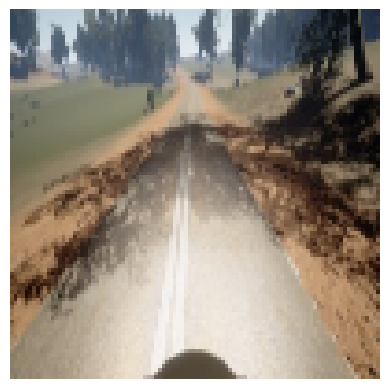

In [11]:
#OPTIONAL
#show random image
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')

In [14]:
def construct_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(100, 100, 3)))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    optimizer = Adam(lr=1e-5)
    model.compile(loss='mae', metrics=['mae'], optimizer = optimizer)
    return model

In [15]:
model = construct_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 48)          43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1164)              1

C:\Users\crist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = model.fit(X_train, Y_train, epochs=500, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/500
37/37 [==============================] - 47s 60ms/step - loss: 0.2015 - mae: 0.2015 - val_loss: 0.1984 - val_mae: 0.1984
Epoch 2/500
37/37 [==============================] - 1s 39ms/step - loss: 0.1924 - mae: 0.1924 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 3/500
37/37 [==============================] - 1s 41ms/step - loss: 0.1806 - mae: 0.1806 - val_loss: 0.1751 - val_mae: 0.1751
Epoch 4/500
37/37 [==============================] - 1s 39ms/step - loss: 0.1624 - mae: 0.1624 - val_loss: 0.1522 - val_mae: 0.1522
Epoch 5/500
37/37 [==============================] - 1s 37ms/step - loss: 0.1425 - mae: 0.1425 - val_loss: 0.1332 - val_mae: 0.1332
Epoch 6/500
37/37 [==============================] - 1s 37ms/step - loss: 0.1245 - mae: 0.1245 - val_loss: 0.1165 - val_mae: 0.1165
Epoch 7/500
37/37 [==============================] - 1s 37ms/step - loss: 0.1099 - mae: 0.1099 - val_loss: 0.1033 - val_mae: 0.1033
Epoch 8/500
37/37 [==============================] - 1s 38ms/step - loss: 0

37/37 [==============================] - 1s 37ms/step - loss: 0.0388 - mae: 0.0388 - val_loss: 0.0533 - val_mae: 0.0533
Epoch 124/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 125/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 126/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0388 - mae: 0.0388 - val_loss: 0.0516 - val_mae: 0.0516
Epoch 127/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0517 - val_mae: 0.0517
Epoch 128/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0525 - val_mae: 0.0525
Epoch 129/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0514 - val_mae: 0.0514
Epoch 130/500
37/37 [==============================] - 1s 36ms/step - loss: 

37/37 [==============================] - 1s 36ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0470 - val_mae: 0.0470
Epoch 246/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0473 - val_mae: 0.0473
Epoch 247/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0472 - val_mae: 0.0472
Epoch 248/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0477 - val_mae: 0.0477
Epoch 249/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0471 - val_mae: 0.0471
Epoch 250/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0470 - val_mae: 0.0470
Epoch 251/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0471 - val_mae: 0.0471
Epoch 252/500
37/37 [==============================] - 1s 36ms/step - loss: 

37/37 [==============================] - 1s 35ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0450 - val_mae: 0.0450
Epoch 368/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0455 - val_mae: 0.0455
Epoch 369/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0452 - val_mae: 0.0452
Epoch 370/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0454 - val_mae: 0.0454
Epoch 371/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 372/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0179 - mae: 0.0179 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 373/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 374/500
37/37 [==============================] - 1s 36ms/step - loss: 

37/37 [==============================] - 1s 35ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 490/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 491/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0438 - val_mae: 0.0438
Epoch 492/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 493/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0436 - val_mae: 0.0436
Epoch 494/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0443 - val_mae: 0.0443
Epoch 495/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 496/500
37/37 [==============================] - 1s 35ms/step - loss: 

Text(0.5, 0, 'Epoch')

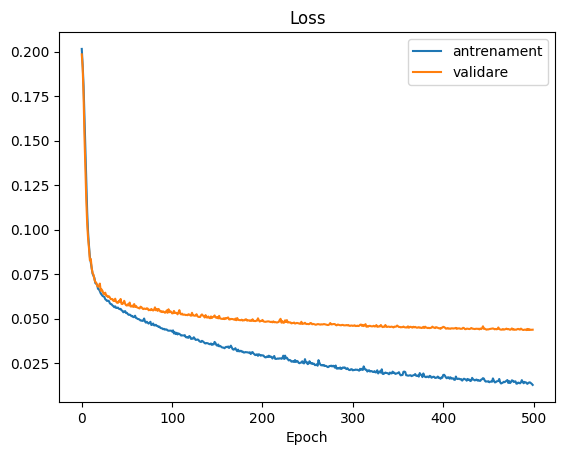

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['antrenament', 'validare'])
plt.title('Loss')
plt.xlabel('Epoch')

In [25]:
## Get any image
for za in range(0,30):
    image = image_paths[za]
    original_image = npimg.imread(image)
    preprocessed_image = img_preprocess(image)

    prediction = model.predict(np.expand_dims(X_valid[za], axis=0))[0]

    print('Prediction:', prediction)
    print('real',Y_valid[za])

1/1 [==============================] - 0s 179ms/step
Prediction: [0.02124385]
real 0.05
1/1 [==============================] - 0s 22ms/step
Prediction: [0.00153236]
real 0.0
1/1 [==============================] - 0s 21ms/step
Prediction: [-0.1699653]
real -0.2
1/1 [==============================] - 0s 23ms/step
Prediction: [0.19515742]
real 0.2
1/1 [==============================] - 0s 23ms/step
Prediction: [-0.24259497]
real -0.3
1/1 [==============================] - 0s 20ms/step
Prediction: [-0.06486311]
real 0.0
1/1 [==============================] - 0s 21ms/step
Prediction: [-0.31691498]
real -0.35
1/1 [==============================] - 0s 23ms/step
Prediction: [-0.13039772]
real -0.1
1/1 [==============================] - 0s 21ms/step
Prediction: [-0.371862]
real -0.35
1/1 [==============================] - 0s 20ms/step
Prediction: [-0.03448969]
real -0.05
1/1 [==============================] - 0s 19ms/step
Prediction: [-0.16301641]
real -0.2
1/1 [==============================] 

In [ ]:

image = image_paths[0]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)
print(preprocessed_image.size)


In [26]:
model.save('mode3.3.h5')

In [ ]:
#used for debuging 
from keras.models import load_model
model = load_model('model1.3.h5')

In [ ]:
plt.imshow(X_train[0])
plt.axis('off')
x = model.predict(np.expand_dims(X_valid[0], axis=0))[0]
print(x)

In [ ]:
#used for testing the onnx model 
import onnxruntime as ort
import numpy as np

# Create an inference session using ONNX Runtime
onnx_model_path = 'The_Model.onnx'
sess = ort.InferenceSession(onnx_model_path)

# Prepare a sample input in the form of a NumPy array
# Replace this with your actual input shape and data type
input_shape = (1, 100, 100, 3)

image = seriImage(X_valid[1])
image = deserie(image)
sample_input = np.expand_dims(X_valid[1], axis=0).astype(np.float32)

   
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Run inference
result = sess.run([output_name], {input_name: sample_input})

# Process the result (e.g., apply softmax or argmax, etc.)
# This depends on the specific model and the output format
print("Inference result:", result)
plt.imshow(X_valid[1])
plt.axis('off')

In [ ]:
#used for debuging 
def deserie(serie):
    # Read the pixel values from the file
    
    pixel_values = serie

    # Convert the pixel values to a numpy array of shape (100, 100, 3) and scale to [0, 255]
    pixel_array = np.array(pixel_values).reshape((100, 100, 3)) * 255


    # Display the image using matplotlib
    plt.imshow(pixel_array.astype(np.uint8))
    plt.show()
    return pixel_array /255

In [ ]:
#used for debuging 
def display_image_from_file(filename):
    # Read the pixel values from the file
    with open(filename, 'r') as f:
        pixel_values = [float(line.strip()) for line in f.readlines()]

    # Convert the pixel values to a numpy array of shape (100, 100, 3) and scale to [0, 255]
    pixel_array = np.array(pixel_values).reshape((100, 100, 3)) * 255


    # Display the image using matplotlib
    plt.imshow(pixel_array.astype(np.uint8))
    plt.show()
    return pixel_array /255

In [ ]:
#used for debuging 
img = display_image_from_file('te.txt')
print(img.shape)

In [ ]:
#used for debuging 
def seriImage(image):
    # Normalize the image to [0, 1]
    normalized_image = image.astype(np.float32)

    # Flatten the image array and convert it to a list of pixel values
    pixel_values = normalized_image.reshape(-1).tolist()
    return pixel_values